# Team Project 4
Members:

Neal Fennimore - nf2137

Nathan Vulakh - nv2155

Mike Dela Calzada - md5286

Miri Alair - mg6931

# Problem 1 

> This is not a code exercise. Students do it manually.

Let 𝐸 be a block cipher of block length 4 that . The following table is used to convert (or encode) an English plaintext into a bit string. Assume we have 16 letters only. Note, if we want a more realistic exercise, we can have block size to be 5 that can represent 32 cases or 8 bits using ASCII.


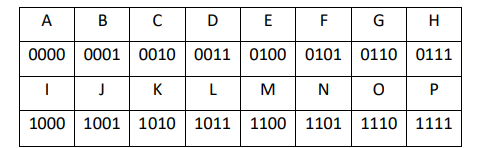

**a)  Given a plaintext message p = ‘FOO’, encrypt it manually using the following operation modes:**
**1) ECB, 2) CBC mode with IV = 1010, 3) CTR mode with ctr = 1010. Make sure you have the final ciphertexts in letters that are easy to transmit to the receiver. Show your work.**

Ek(b1b2b3b4) = b2b3b1b4

F = 0101

O = 1110


**ECB**

F(0101) -> Ek(b1b2b3b4) = b2b3b1b4 -> 1001 = J

O (1110) ->  Ek(b1b2b3b4) = b2b3b1b4 -> 1110 = O 

O (1110) ->  Ek(b1b2b3b4) = b2b3b1b4 -> 1110 = O 

<br>

The encrypted message of the plaintext 'FOO' for ECB is 'JOO'

**CBC** 

IV = 1010

F(0101) XOR IV(1010) = 1111

1111 -> Ek(b1b2b3b4) = b2b3b1b4 -> 1111 = P

<br>

O(1110) XOR IV(1111) = 0001 

0001 -> Ek(b1b2b3b4) = b2b3b1b4 -> 0001 = B

<br>

O(1110) XOR IV(0001) = 1111

1111 -> Ek(b1b2b3b4) = b2b3b1b4 -> 1111 = P

<br>

The encrypted message of the plaintext 'FOO' for CBC is 'PBP'

**CTR** 

ctr = 1010

ctr(1010) -> Ek(b1b2b3b4) = b2b3b1b4 -> 0110

F(0101) XOR 0110 = 0011 = D

<br>

ctr = (1010) + (0001) = 1011

ctr(1011) -> Ek(b1b2b3b4) = b2b3b1b4 -> 0111

O(1110) XOR 0111 = 1001 = J

<br>

ctr = (1011) + (0001) = 1100

ctr(1100) -> Ek(b1b2b3b4) = b2b3b1b4 -> 1010

O(1110) XOR 1010 = 0100 = E 

<br>

The encrypted message of the plaintext 'FOO' for CTR is 'DJE'


**b) Assume the cyphertexts are sent to an intended receiver. The receiver needs to decrypt them to recover the original plaintext. Please do the decryption manually based on the above three cases. Show your work.** 

**ECB**

'JOO' is the encrypted message, to decrypt it back to its plaintext, we will be doing the following:

J(1001) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 0101 = F 

O(1110) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 1110 = O

O(1110) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 1110 = O

<br>

The plaintext is 'FOO'

**CBC** 

'PBP' is the encrypted message, to decrypt it back to its plaintext with IV = 1010, we will be doing the following:

P(1111) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 1111

1111 XOR IV(1010) = 0101 = F

<br>

B(0001) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 0001

0001 XOR IV(1111) = 1110 = O

<br>

P(1111) -> Ek^-1(b2b3b1b4) = b1b2b3b4 -> 1111

1111 XOR IV(0001) = 1110 = O

<br>

The plaintext is 'FOO'

**CTR**

'DJE' is the encrypted message, to decrypt it back to its plaintext with ctr = 1010, we will be doing the following:

ctr = 1010

Ek(1010) = 0110

D(0011) XOR 0110 = 0101 = F

<br>

ctr = 1011 

Ek(1011) = 0111

J(1001) XOR 0111 = 1110 = O

<br>

ctr = 1100

Ek(1100) = 1010

E(0100) XOR 1010 = 1110 = O

<br>

The plaintext is 'FOO'


# Problem 2

In [8]:
from typing import List, Tuple, Optional, Iterator

sbox = bytearray([
    0x9, 0x4, 0xa, 0xb,
    0xd, 0x1, 0x8, 0x5,
    0x6, 0x2, 0x0, 0x3,
    0xc, 0xe, 0xf, 0x7
])
 
inverse_sbox = bytearray([
    0xa, 0x5, 0x9, 0xb,
    0x1, 0x7, 0x8, 0xf,
    0x6, 0x0, 0x2, 0x3,
    0xc, 0x4, 0xd, 0xe
])

class Nibble(int):
    def __init__(self, _, **kwargs):
        assert self <= 15

class Byte(int):
    def __init__(self, _, **kwargs):
        assert self <= 255

    def to_nibbles(self):
        return [Nibble(self >> 4), Nibble(self & 0xF)]

class Word(int):
    def __init__(self, _, **kwargs):
        assert self <= 65535

    def to_bytes(self):
        return [Byte(self >> 8), Byte(self & 0xFF)]
    
    def to_nibbles(self):
        return [nibble for b in self.to_bytes() for nibble in b.to_nibbles()]
    
    def swap_nibbles(self, a: int, b: int):
        nibbles = self.to_nibbles()
        nibbles[a], nibbles[b] = nibbles[b], nibbles[a]
        return Word.from_nibbles(nibbles)
    
    @staticmethod
    def from_nibbles(n: List[Nibble] | List[int]):
        return Word((n[0] << 12) + (n[1] << 8) + (n[2] << 4) + n[3])

w = Word(65535)
assert w.to_nibbles() == [15,15,15,15]
assert w.to_bytes() == [255, 255]
assert w == Word.from_nibbles(w.to_nibbles())

class Key(Word):
    pass

Keys = Tuple[Key, Key, Key]

class KeyGen:
    def __init__(self, K: Word, sbox: bytearray):
        self.K = K
        self.sbox = sbox

    def gen(self) -> Keys:
        r0, r1 = 0x80, 0x30

        w0, w1 = self.K.to_bytes()
        w2 = w0 ^ r0 ^ self.substitute(w1)
        w3 = w2 ^ w1
        w4 = w2 ^ r1 ^ self.substitute(Byte(w3))
        w5 = w4 ^ w3

        k0 = (w0 << 8) + w1
        k1 = (w2 << 8) + w3
        k2 = (w4 << 8) + w5

        return Key(k0), Key(k1), Key(k2)

    def substitute(self, b: Byte):
        high, low = b.to_nibbles()
        return self.sbox[high] + (self.sbox[low] << 4)

K = Word(0x4AF5)
k0, k1, k2 = KeyGen(K, sbox).gen()
assert KeyGen(K, sbox).gen() == (0x4AF5, 0xDD28, 0x87AF)

class SAES:
    sbox: bytearray = sbox
    inverse_sbox: bytearray = inverse_sbox

    @staticmethod
    # From https://jhafranco.com/2012/02/11/simplified-aes-implementation-in-python/
    def GF(p1: int, p2: int):
        """Multiply two polynomials in GF(2^4)/x^4 + x + 1"""
        p = 0
        while p2:
            if p2 & 0b1:
                p ^= p1
            p1 <<= 1
            if p1 & 0b10000:
                p1 ^= 0b11
            p2 >>= 1
        return p & 0b1111

    def _encrypt_gen(self, P: int, K: int) -> Iterator[Word]:
        def mix_columns(w: Word):
            n = w.to_nibbles()
            return Word.from_nibbles([
                n[0] ^ SAES.GF(4, n[1]),
                n[1] ^ SAES.GF(4, n[0]),
                n[2] ^ SAES.GF(4, n[3]),
                n[3] ^ SAES.GF(4, n[2])
            ])


        k0, k1, k2 = KeyGen(Word(K), self.sbox).gen()

        # Round 1
        s = Word(P ^ k0)
        yield s

        # Round 2
        s = Word.from_nibbles([
            self.sbox[i] for i in s.to_nibbles()
        ])
        s = s.swap_nibbles(1, 3)
        s = mix_columns(s)
        s = Word(s ^ k1)
        yield s

        # Round 3
        s = Word.from_nibbles([
            self.sbox[i] for i in s.to_nibbles()
        ])
        s = s.swap_nibbles(1, 3)
        yield Word(s ^ k2)

    def encrypt(self, P: int, K: int, rounds: int = 3) -> Word:
        assert rounds <= 3 and rounds > 0
        gen = self._encrypt_gen(P, K)
        result: Optional[Word] = None
        for _ in range(rounds):
            result = next(gen)
        assert result is not None
        return result

    def _decrypt_gen(self, C: int, K: int) -> Iterator[Word]:
        def inverse_mix_columns(w: Word):
            n = w.to_nibbles()
            return Word.from_nibbles([
                SAES.GF(9, n[0]) ^ SAES.GF(2, n[1]),
                SAES.GF(9, n[1]) ^ SAES.GF(2, n[0]),
                SAES.GF(9, n[2]) ^ SAES.GF(2, n[3]),
                SAES.GF(9, n[3]) ^ SAES.GF(2, n[2])
            ])
     
        k0, k1, k2 = KeyGen(Word(K), self.sbox).gen()

        # Round 1
        s = Word(C ^ k2)
        s = s.swap_nibbles(1, 3)
        s = Word.from_nibbles([
            self.inverse_sbox[i] for i in s.to_nibbles()
        ])
        yield s

        # Round 2
        s = Word(s ^ k1)
        s = inverse_mix_columns(s)
        s = s.swap_nibbles(1, 3)
        s = Word.from_nibbles([
            self.inverse_sbox[i] for i in s.to_nibbles()
        ])
        yield s

        # Round 3
        yield Word(s ^ k0)

    def decrypt(self, C: int, K: int, rounds: int = 3) -> Word:
        assert rounds <= 3 and rounds > 0
        gen = self._decrypt_gen(C, K)
        result: Optional[Word] = None
        for _ in range(rounds):
            result = next(gen)
        assert result is not None
        return result

# Test cases from https://sandilands.info/sgordon/teaching/reports/simplified-aes-example.pdf
K = 0x4AF5
P = 0xD728
saes = SAES()
C = saes.encrypt(P, K)
assert saes.encrypt(P, K) == 0x24EC
assert saes.decrypt(C, K) == P

for P in range(65356):
    assert saes.decrypt(saes.encrypt(P, K), K) == P

## Test Scenario 1

> Select key size = 16, the block size =16. This is the typical case on the simplified AES as explained in the slides. It is easy to get the possible key space is 216 = 65536. The match two keys using exhausted method would be 65536x65536 = 4,294,967,296. Clearly, your testing machine needs to be powerful. If you cannot get the results fast enough, summarize it and move to the dummy test scenario 2. That is the nature of cryptoanalysis. But if you get what you want, you do not need to go to the dummy case.

In [11]:
saes = SAES()

def meet_in_the_middle_attack(C: int, P: int) -> Optional[int]:

    def generate_key_space():
        for k0 in range(65536):
            for k2 in range(65536):
                yield (k0, k2)


    for k0, k2 in generate_key_space():
        if saes.encrypt(P, k0, rounds=1) == saes.decrypt(C, k2, rounds=2):
            print(f"Trying potential keys: {k0}, {k2}")

            P2 = 0xFFFF
            C2 = saes.encrypt(P2, k0)

            if saes.encrypt(P2, k0, rounds=1) == saes.decrypt(C2, k2, rounds=2):
                print(f"Success: round keys are {KeyGen(Word(k0), saes.sbox).gen()}")
                return k0

    return None


for i in range(5):
    K = 0x0000 + i
    P = 0xD728
    C = saes.encrypt(P, K)

    assert meet_in_the_middle_attack(C, P) == K

Trying potential keys: 0, 0
Success: round keys are (0, 6425, 3348)
Trying potential keys: 0, 34361
Trying potential keys: 0, 34933
Trying potential keys: 1, 1
Success: round keys are (1, 51656, 38237)
Trying potential keys: 0, 3834
Trying potential keys: 0, 65487
Trying potential keys: 2, 2
Success: round keys are (2, 10539, 8968)
Trying potential keys: 1, 12364
Trying potential keys: 1, 61920
Trying potential keys: 2, 40187
Trying potential keys: 2, 46784
Trying potential keys: 2, 48781
Trying potential keys: 3, 3
Success: round keys are (3, 14650, 568)
Trying potential keys: 1, 16689
Trying potential keys: 2, 1718
Trying potential keys: 2, 45454
Trying potential keys: 4, 4
Success: round keys are (4, 22877, 35029)


## Test Scenario 2

> Select key size = 8, the block size = 8. This is the reduced simplified AES (rSAES). In this case, the possible key space is 2^8 = 256. The match two keys using exhausted method would be 256x256 = 65536, a huge reduction in test cases. And it should be manageable.


In [15]:

def meet_in_the_middle_attack(C: int, P: int) -> Optional[int]:

    def generate_key_space():
        for k0 in range(256):
            for k2 in range(256):
                yield (k0, k2)


    for k0, k2 in generate_key_space():
        if saes.encrypt(P, k0, rounds=1) == saes.decrypt(C, k2, rounds=2):
            print(f"Trying potential keys: {k0}, {k2}")

            P2 = 0xF0
            C2 = saes.encrypt(P2, k0)

            if saes.encrypt(P2, k0, rounds=1) == saes.decrypt(C2, k2, rounds=2):
                print(f"Success: round keys are {KeyGen(Word(k0), saes.sbox).gen()}")
                return k0

    return None


for i in range(5):
    K = 0x00 + i
    P = 0xD7
    C = saes.encrypt(P, K)

    assert meet_in_the_middle_attack(C, P) == K

Trying potential keys: 0, 0
Success: round keys are (0, 6425, 3348)
Trying potential keys: 1, 1
Success: round keys are (1, 51656, 38237)
Trying potential keys: 2, 2
Success: round keys are (2, 10539, 8968)
Trying potential keys: 3, 3
Success: round keys are (3, 14650, 568)
Trying potential keys: 4, 4
Success: round keys are (4, 22877, 35029)


## Questions

> 1. Can you find the matched keys in the simplified AES case? If not, can you do in the reduced simplified AEs (dummy) test scenario?

Yes, test scenario 1 can find it's own key. Test Scenario 2 can find its own key as well. Because the key space is smaller, it is significantly faster to crack Scenario 2 than scenario 1. 

> 2. Analyze the time and memory complexity of the attack compared with the naive exhaustive key search.

The time complexity for scenario 1, where $n = 65536$ is $3(n^2) + n^4$ or $O(n^4)$. In the example code given for meet in the middle attack code skeleton, the memory complexity would also be $3(n^2)$ due to all the arrays storing outputs.

In our code, we've reduced memory down to a constant by using a generator, as it will only allocate one iteration of the $65536 \times 65536$ key loop as needed, and removes the need for creating the entire keyspace lookup table, as well as the key outputs. The attack also only needs to run in $O(n^2)$ now, since we only iterate over the needed keyspace, and assuming decryption and encryption always takes a constant $c$ when the corresponding rounds would intersect, the attack will run in $2c(n^2)$.

> 3. Discuss how increasing the number of rounds exponentially increases the difficulty of the attack.

The number of rounds increases the difficulty of the attack, as it directly affects how many rounds we need to encrypt and decrypt per iteration. In our example code,we only had 3 rounds per encryption and decryption, so $r=3$, but we only ran one one encryption and 2 rounds on decryption.

$$
\begin{align}
ENC_{p,k} &= 3r \\
DEC_{c,k} &= 3r \\\\
\text{Where our algorithm ran in:} \\ 
n^2 (\frac{ENC_{p,k}}{3} + 2\frac{DEC_{c,k}}{3}) &= \\
&= n^2 (\frac{3r}{3} + 2\frac{3r}{3}) \\
&= n^2 (r + 2r) \\
&= n^2 (3r) \\
\end{align}
$$

If we double the rounds in a new algorithm for the meet in the middle attack, and only encrypt once, we still need 5 rounds for decryption to get to the same key:

$$
\begin{align}
ENC_{p,k} &= 6r \\
DEC_{c,k} &= 6r \\
n^2 (\frac{ENC_{p,k}}{6} + 5\frac{DEC_{c,k}}{6}) &= \\
&= n^2 (\frac{6r}{6} + 5\frac{6r}{6}) \\
&= n^2 (r + 5r) \\
&= n^2 (6r) \\
\end{align}
$$

However, this is still a quadratic difficulty.